<a href="https://colab.research.google.com/github/KaranKhirsariya/machine-learning/blob/master/Deep_Conv_Generative_Adversial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Copyright 2019 The TensorFlow Authors***

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Deep Conv Generative Adversial Networks

This tutorial demonstrates how to generate images of handwritten digits using a [Deep Convolutional Generative Adversarial Network](https://arxiv.org/pdf/1511.06434.pdf) (DCGAN). The code is written using the [Keras Sequential API](https://www.tensorflow.org/guide/keras) with a `tf.GradientTape` training loop.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install tensorflow==2.0.0-beta1

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense, Conv2D, Conv2DTranspose, Reshape,
                                    BatchNormalization, MaxPooling2D, LeakyReLU,
                                    Dropout, Flatten)
from tensorflow.keras.models import Sequential

In [0]:
# To generate GIFs
!pip install imageio

In [0]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display

### Load and prepare the dataset
You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [0]:
(train_images, train_labels), (_,_) = tf.keras.datasets.mnist.load_data()

In [0]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1,1]

In [0]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [0]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Create the models

Both the generator and discriminator are defined using the Keras Sequential API.

### The Generator

The generator uses `tf.keras.layers.Conv2Transpose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense`  layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which users tanh.

In [0]:
def make_generator_model():
  model = tf.keras.Sequential()
  model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) 
  # Note: None is the batch size

  model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same'
                                   , use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same',
                                   use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(BatchNormalization())
  model.add(LeakyReLU())

  model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same',
                                   use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)

  return model

Use the (as yet untraind) generator to create an image.

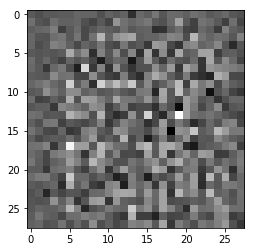

In [0]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0], cmap='gray')


## The Discriminator

The discriminator is a CNN-based image classifier.


In [0]:
def make_discriminator_model():
  model = tf.keras.Sequential()
  model.add(Conv2D(64, (5,5), strides=(2,2), padding='same', 
                   input_shape=[28,28,1]))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU())
  model.add(Dropout(0.3))
  
  model.add(Flatten())
  model.add(Dense(1))
  
  return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [0]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00352912]], shape=(1, 1), dtype=float32)


# Define the loss and optimizers

Define loss functions and optimizer for both models.

In [0]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real numbers from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discrinimator's predictions on fake (generated) images to an array of 0s.

In [0]:
def discriminator_loss(real_op, fake_op):
  real_loss = cross_entropy(tf.ones_like(real_op), real_op)
  fake_loss = cross_entropy(tf.zeros_like(fake_op), fake_op)
  total_loss = real_loss + fake_loss
  return total_loss


## Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [0]:
def generator_loss(fake_op):
  return cross_entropy(tf.ones_like(fake_op), fake_op)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [0]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoints_prefix = os.path.join(checkpoint_dir,"ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

## Define the training loop

In [0]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF

seed = tf.random.normal([num_examples_to_generate, noise_dim])



*  The training loop begins with generator receiving a random seed as input.
*  That seed is used to produce an image.
*  The discriminator is then used to classify real images ( drawn from the training set) and fake images (produced by the generator).
*  The loss is calculated for each of these models, and gradients are used to udpate the generator and discriminator


In [0]:
# This annotation causes the function to be "compiled"
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])
  
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    
    real_op = discriminator(images, training=True)
    fake_op = discriminator(generated_images, training=True)
    
    gen_loss = generator_loss(fake_op)
    disc_loss = discriminator_loss(real_op, fake_op)
    
  gradients_of_generator = gen_tape.gradient(gen_loss,
                                              generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                 discriminator.trainable_variables)
  
  generator_optimizer.apply_gradients(zip(gradients_of_generator, 
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, 
                                            discriminator.trainable_variables))

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()
    
    for image_batch in dataset:
      train_step(image_batch)
    
    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)
    
    # save the model every 15 epochs
    
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Time for epoch {} is {} sec'.format(epoch+1, time.time()-start))
    
  # generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

In [0]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False;
  # This is so all layers run in inference mode (batchnorm).
  
  predictions = model(test_input, training=False)
  
  fig = plt.figure(figsize=(4,4))
  
  for i in range(predictions.shape[0]):
    plt.subplot(4,4,i+1)
    plt.imshow(predictions[i,:,:,0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
  
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

---
## Train the model
call the `train()` method defined above to train the generator and discriminator simultaneously.
Note, trianing GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at similar rate)

At the beginning of the training, the gneerated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute/ epoch with the default settings on colab.

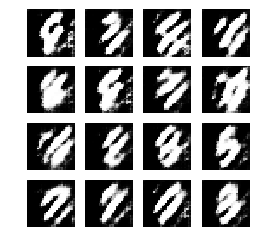

Time for epoch 2 is 855.6428678035736 sec


KeyboardInterrupt: ignored

In [0]:
%%time
train(train_dataset, EPOCHS)

Restore the latest checkpoint

In [0]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

---
# Create a GIF

